
1. Load the houseprices data from Thinkful's database.
2. Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But make sure that your work is satisfactory.
3. Now, split your data into train and test sets where 20% of the data resides in the test set.
4. Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!
5. Evaluate your best model on the test set.
6. So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from sqlalchemy import create_engine
from scipy.stats import bartlett
from scipy.stats import levene
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import normalize
from statsmodels.tsa.stattools import acf
import statsmodels.api as sm
import seaborn as sns
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import cross_val_score

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
houseprices = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

2. Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But make sure that your work is satisfactory.

## Missing Values

We have 1,460 datapoints and eighty-one columns for seventy-nine variables (we will not include the ID column). Many of the columns are not missing any values, thirteen columns are missing fewer than one hundred values, one column is missing approximately half its values, and the rest are missing at least 80% of values.

I will drop alley, poolqc, fence, and miscfeature, all of which are missing values at least 80% of the cells.

Eight of the columns with missing values hold information on either the basement or the garage. These sets are missing the same amount of data, so my instinct is that the houses missing the data simply did not have basements or garage - therefore, I'll replace the missing values with None to create a new category.

I'll use interpolation on lotfrontage as this column has float values and is missing less than 10% of the data. This variable has fairly strong correlations with firstflrsf and lotarea, so I'm going to sort the data by these two columns and then interpolate lotfrontage.

According to the correlation matrix, there is a very strong correlation between garageyrblt and yearbuilt, so I'm going to fill all missing values in garageyrblt with those in yearbuilt, as I think this is the best way to fill all values and keep the integrity of the data. This increased the correlation between saleprices and garageyrblt by 0.022 - it would be prudent to keep this in mind during our analysis.

Finally, electrical is missing one value. As over 90% of electrical is SBrkr, I will insert this value into the missing cell.

## Features

Variables overallqual (0.791), grlivarea (0.709), garagecars (0.640), garagearea (0.623), totalbsmtsf (0.614), and firstflrsf (0.606) are all strongly positively correlated with saleprices, our target variable. I will start by including these in our model, whether they're on their own or combined. Below is a list of variable pairs along with their correlations that I will combine into features. 


In [2]:
houseprices = houseprices.drop(['alley', 'poolqc', 'fence', 'miscfeature'], axis=1)

In [3]:
houseprices.electrical.value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: electrical, dtype: int64

In [4]:
# Handling missing values
houseprices['masvnrtype'].fillna('None', inplace=True) # filling NaN values with 'None'
houseprices['bsmtqual'].fillna('None', inplace=True) # filling NaN values with 'None'
houseprices['bsmtcond'].fillna('None', inplace=True) # filling NaN values with 'None'
houseprices['bsmtexposure'].fillna('None', inplace=True) # filling NaN values with 'None'
houseprices['bsmtfintype1'].fillna('None', inplace=True) # filling NaN values with 'None'
houseprices['bsmtfintype2'].fillna('None', inplace=True) # filling NaN values with 'None'
houseprices['garagetype'].fillna('None', inplace=True) # filling NaN values with 'None'
houseprices['garagefinish'].fillna('None', inplace=True) # filling NaN values with 'None'
houseprices['garagequal'].fillna('None', inplace=True) # filling NaN values with 'None'
houseprices['garagecond'].fillna('None', inplace=True) # filling NaN values with 'None'
houseprices['fireplacequ'].fillna('None', inplace=True) # filling NaN values with 'None'
houseprices['electrical'].fillna('SBrkr', inplace=True) # filling NaN values with 'SBrkr'
houseprices['garageyrblt'].fillna(houseprices['yearbuilt'], inplace=True) # filling NaN values with 'None'
houseprices['masvnrarea'].fillna(0.00, inplace=True) # filling NaN values with 'SBrkr'

In [5]:
houseprices.sort_values(['firstflrsf', 'lotarea'], ascending=[True, True])
# houseprices["lotfrontage"].fillna(houseprices["lotfrontage"].mean(), inplace=True)
houseprices['lotfrontage'] = houseprices.lotfrontage.interpolate(method ='linear', limit_direction ='forward')
# houseprices.info()

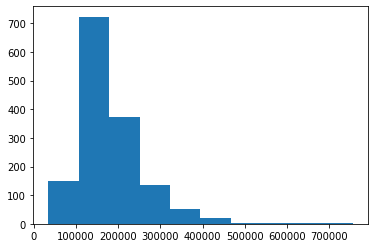

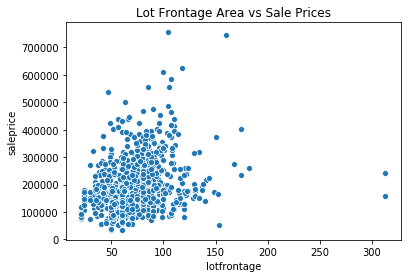

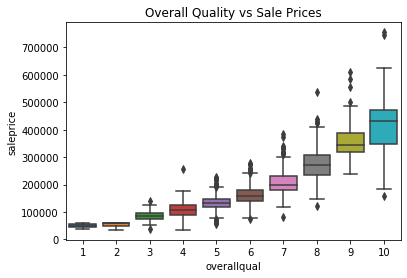

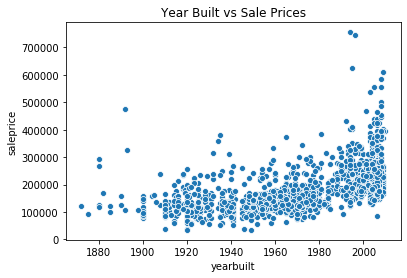

No handles with labels found to put in legend.


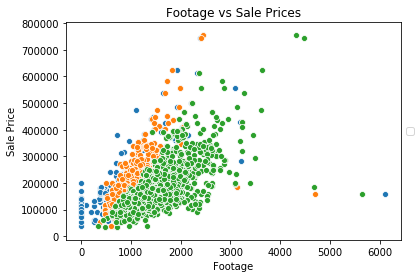

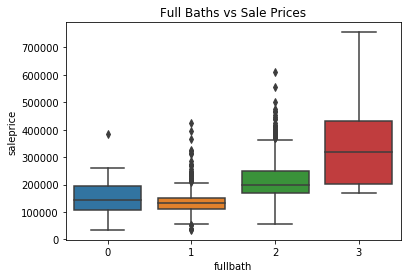

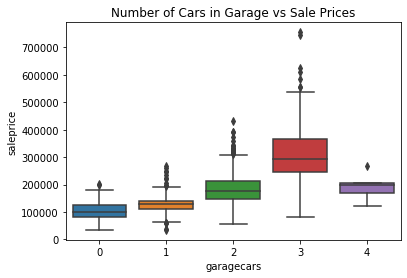

In [6]:
# Data visualization

plt.hist(houseprices['saleprice'])
plt.show()

sns.scatterplot(x='lotfrontage', y='saleprice', data=houseprices)
plt.title('Lot Frontage Area vs Sale Prices')
plt.show()

sns.boxplot(x='overallqual', y='saleprice', data=houseprices)
plt.title('Overall Quality vs Sale Prices')
plt.show()

sns.scatterplot(x='yearbuilt', y='saleprice', data=houseprices)
plt.title('Year Built vs Sale Prices')
plt.show()

sns.scatterplot(x='totalbsmtsf', y='saleprice', data=houseprices)
sns.scatterplot(x='firstflrsf', y='saleprice', data=houseprices)
sns.scatterplot(x='grlivarea', y='saleprice',  data=houseprices)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Footage vs Sale Prices')
plt.xlabel('Footage')
plt.ylabel('Sale Price')
plt.show()

# sns.lmplot(x='grlivarea', y='saleprice', hue=['totalbsmtsf', 'firstflrsf'],  data=houseprices)
# sns.lmplot(x='totalbsmtsf', y='saleprice', data=houseprices)
# sns.lmplot(x='firstflrsf', y='saleprice', data=houseprices)
# plt.show()
# sns.lmplot(x='totalbsmtsf', y='saleprice', data=houseprices)
# sns.lmplot(x='firstflrsf', y='saleprice', data=houseprices)
# sns.lmplot(x='grlivarea', y='saleprice',  data=houseprices)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.title('Footage vs Sale Prices')
# plt.xlabel('Footage')
# plt.ylabel('Sale Price')
# plt.show()

sns.boxplot(x='fullbath', y='saleprice', data=houseprices)
plt.title('Full Baths vs Sale Prices')
plt.show()

sns.boxplot(x='garagecars', y='saleprice', data=houseprices)
plt.title('Number of Cars in Garage vs Sale Prices')
plt.show()

In [7]:
# Combining variables into features

houseprices['square_footage'] = houseprices.totalbsmtsf * houseprices.firstflrsf # 
houseprices['garage_cars_area'] = houseprices.garagecars * houseprices.garagearea # 
houseprices['year_garage'] = houseprices.yearbuilt * houseprices.garageyrblt # 
houseprices['area_rooms'] = houseprices.grlivarea * houseprices.totrmsabvgrd # 


In [9]:
# Dealing with outliers and normalizing our features and target

houseprices["winsorized_footage"] = winsorized_lotfrontage = winsorize(houseprices['square_footage'], (0, 0.10))
houseprices["norm_winsorized_footage"] = normalize(np.array(houseprices["winsorized_footage"]).reshape(1,-1)).reshape(-1,1)
houseprices["winsorized_garage"] = winsorized_totalbsmtsf = winsorize(houseprices['garage_cars_area'], (0, 0.10))
houseprices["norm_winsorized_garage"] = normalize(np.array(houseprices["winsorized_garage"]).reshape(1,-1)).reshape(-1,1)
houseprices["winsorized_year_garage"] = winsorized_firstflrsf = winsorize(houseprices['year_garage'], (0, 0.10))
houseprices["norm_winsorized_year_garage"] = normalize(np.array(houseprices["winsorized_year_garage"]).reshape(1,-1)).reshape(-1,1)
houseprices["winsorized_area_rooms"] = winsorized_grlivarea = winsorize(houseprices['area_rooms'], (0, 0.10))
houseprices["norm_winsorized_area_rooms"] = normalize(np.array(houseprices["winsorized_area_rooms"]).reshape(1,-1)).reshape(-1,1)
houseprices["winsorized_saleprice"] = winsorized_grlivarea = winsorize(houseprices['saleprice'], (0, 0.10))
houseprices["norm_winsorized_saleprice"] = normalize(np.array(houseprices["winsorized_saleprice"]).reshape(1,-1)).reshape(-1,1)



houseprices["norm_overallqual"] = normalize(np.array(houseprices["overallqual"]).reshape(1,-1)).reshape(-1,1)
# houseprices["norm_fullbath"] = normalize(np.array(houseprices["fullbath"]).reshape(1,-1)).reshape(-1,1)
# houseprices["garagecars"] = normalize(np.array(houseprices["garagecars"]).reshape(1,-1)).reshape(-1,1)


3. Now, split your data into train and test sets where 20% of the data resides in the test set.

4. Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!

## OLS/Linear Regression Model without Training Sets

The R-squared/adjusted values are reasonably high at 0.82, indicating that this model is a good fit. The condition number is large indicating there may be strong multicollinearity, so we'll keep an eye on this on other models.

The model is:

norm_winsorized_saleprice = -0.05445925 + 0.51620053(norm_overallqual) + 0.13761146(norm_winsorized_footage) +  0.0683138(norm_winsosized_garage) + 2.14127556(norm_winsorized_year_garage) + 0.22889553(norm_winsorized_area_rooms)

In [10]:
X = houseprices[['norm_overallqual', 'norm_winsorized_footage', 'norm_winsorized_garage', 'norm_winsorized_year_garage', 'norm_winsorized_area_rooms']]
Y = houseprices[['norm_winsorized_saleprice']]
lrm = linear_model.LinearRegression()

lrm.fit(X,Y)
print("The number of observations in training set is {}".format(X.shape[0]))
print("The number of observations in test set is {}".format(X.shape[0]))
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)
X_const = sm.add_constant(X)

# We fit an OLS model using statsmodels
results = sm.OLS(Y, X_const).fit()

# We print the summary results
print(results.summary())


The number of observations in training set is 1460
The number of observations in test set is 1460

Coefficients: 
 [[0.51620053 0.13761146 0.0683138  2.14127556 0.22889553]]

Intercept: 
 [-0.05445925]
                                OLS Regression Results                               
Dep. Variable:     norm_winsorized_saleprice   R-squared:                       0.821
Model:                                   OLS   Adj. R-squared:                  0.820
Method:                        Least Squares   F-statistic:                     1332.
Date:                       Sat, 15 Feb 2020   Prob (F-statistic):               0.00
Time:                               21:01:58   Log-Likelihood:                 6169.4
No. Observations:                       1460   AIC:                        -1.233e+04
Df Residuals:                           1454   BIC:                        -1.230e+04
Df Model:                                  5                                         
Covariance Type:        

## OLS/Linear Regression Model with Training Sets

This model has relatively high R-squared and R-squared adjusted values at 0.82 and the value for the test set is actually higher, which means our model accounts for much of the variation of the data but makes me think that we may have overfitting taking place. The p-value for the F-test is zero, indicating that our model is a better fit than not having a model/is significant.


In [27]:
X = houseprices[['norm_overallqual', 'norm_winsorized_footage', 'norm_winsorized_garage', 'norm_winsorized_year_garage', 'norm_winsorized_area_rooms']]
Y = houseprices[['norm_winsorized_saleprice']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .2, random_state = 465)
print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# We fit an OLS model using statsmodels
results_train = sm.OLS(Y_train, X_train_const).fit()


results_test = sm.OLS(Y_test, X_test_const).fit()
# We print the summary results
print(results_train.summary())
print('\n')
print(results_test.summary())


The number of observations in training set is 1168
The number of observations in test set is 292
                                OLS Regression Results                               
Dep. Variable:     norm_winsorized_saleprice   R-squared:                       0.821
Model:                                   OLS   Adj. R-squared:                  0.820
Method:                        Least Squares   F-statistic:                     1068.
Date:                       Wed, 06 Nov 2019   Prob (F-statistic):               0.00
Time:                               10:06:56   Log-Likelihood:                 4943.3
No. Observations:                       1168   AIC:                            -9875.
Df Residuals:                           1162   BIC:                            -9844.
Df Model:                                  5                                         
Covariance Type:                   nonrobust                                         
                                  coef    s

## Lasso Regression Model 

The R-squared values are zero, indicating the model doesn't account for any correlation between features and the target.

In [11]:
X = houseprices[['norm_overallqual', 'norm_winsorized_footage', 'norm_winsorized_garage', 'norm_winsorized_year_garage', 'norm_winsorized_area_rooms']]
Y = houseprices[['norm_winsorized_saleprice']]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .2, random_state = 465)
print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))
print('\n')

X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

lassoregr = Lasso(alpha=1000)
lassoregr.fit(X_train, Y_train)

# We are making predictions here
Y_preds_train = lassoregr.predict(X_train)
Y_preds_test = lassoregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(lassoregr.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test['norm_winsorized_saleprice'], Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test['norm_winsorized_saleprice'] - Y_preds_test) / Y_test['norm_winsorized_saleprice'])) * 100))



The number of observations in training set is 1168
The number of observations in test set is 292


R-squared of the model on the training set is: 0.0
-----Test set statistics-----
R-squared of the model on the test set is: -0.0033490294027871403
Mean absolute error of the prediction is: 0.007116591246320004
Mean squared error of the prediction is: 7.275206470044461e-05
Root mean squared error of the prediction is: 0.008529482088640824
Mean absolute percentage error of the prediction is: 33.63888162497225


## Lasso Regression Model with Cross Validation 

The Lasso model with cross validation gives a strong R-squared of 0.82 for the training set and 0.81 for the test set, indicating this is a good model for the data. The evaluation metrics appear low, but I'd like to compare them to the metrics of the OLS model. 

In [44]:
print('Lasso Regression with Cross Validation:')
lassoregrCV = LassoCV(n_alphas=5)
lassoregrCV.fit(X_train, Y_train)

# We are making predictions here
Y_preds_train = lassoregrCV.predict(X_train)
Y_preds_test = lassoregrCV.predict(X_test)

print("R-squared of the model on the training set is: {}".format(lassoregrCV.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregrCV.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test['norm_winsorized_saleprice'], Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test['norm_winsorized_saleprice'] - Y_preds_test) / Y_test['norm_winsorized_saleprice'])) * 100))


Lasso Regression with Cross Validation:
R-squared of the model on the training set is: 0.8209067881990664
-----Test set statistics-----
R-squared of the model on the test set is: 0.8144890249733847
Mean absolute error of the prediction is: 0.0026634869366510645
Mean squared error of the prediction is: 1.3451257799902543e-05
Root mean squared error of the prediction is: 0.0036675956429113804
Mean absolute percentage error of the prediction is: 12.194417667428564


## Ridge Regression Model

The OLS and Lasso models are clearly better with much larger R-squared values and relatively similar evaluation metrics.

In [14]:
# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced.
ridgeregr = Ridge(alpha=0.1) 
ridgeregr.fit(X_train, Y_train)

# We are making predictions here
Y_preds_train = ridgeregr.predict(X_train)
Y_preds_test = ridgeregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

R-squared of the model on the training set is: 0.721379463120583
-----Test set statistics-----
R-squared of the model on the test set is: 0.7021849830548679
Mean absolute error of the prediction is: 0.003472303397517768
Mean squared error of the prediction is: [2.15943373e-05]
Root mean squared error of the prediction is: [0.00464697]
Mean absolute percentage error of the prediction is: norm_winsorized_saleprice   16.125
dtype: float64


## Ridge Regression with Cross Validation

The Ridge model with cross validation performs simliarly enough to the Ridge model that I'm comfortable saying there's no significance between the two. 

In [15]:
ridgeCV = RidgeCV(alphas=(0.1, 1.0, 10.0, 50, 10000))
ridgeCV.fit(X_train, Y_train)

# We are making predictions here
Y_preds_train = ridgeCV.predict(X_train)
Y_preds_test = ridgeCV.predict(X_test)

print("R-squared of the model on the training set is: {}".format(ridgeCV.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeCV.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))


R-squared of the model on the training set is: 0.7213794631205834
-----Test set statistics-----
R-squared of the model on the test set is: 0.7021849830548683
Mean absolute error of the prediction is: 0.003472303397517764
Mean squared error of the prediction is: 2.1594337310968098e-05
Root mean squared error of the prediction is: [0.00464697]
Mean absolute percentage error of the prediction is: norm_winsorized_saleprice   16.125
dtype: float64


## ElasticNet Regression Model

While the ElasticNet model performs slightly better than the Lasso model, this is only true when alpha is set to 0. Changing the l1_ratio doesn't change the evaluation metrics.

In [55]:
elasticregr = ElasticNet(l1_ratio=1000, alpha=0) 
elasticregr.fit(X_train, Y_train)

# We are making predictions here
Y_preds_train = elasticregr.predict(X_train)
Y_preds_test = elasticregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(elasticregr.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(sqrt(mean_squared_error(Y_test, Y_preds_test))))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test['norm_winsorized_saleprice'] - Y_preds_test)/Y_test['norm_winsorized_saleprice']) * 100)))

R-squared of the model on the training set is: 0.8212490083631951
-----Test set statistics-----
R-squared of the model on the test set is: 0.8171144814116756
Mean absolute error of the prediction is: 0.002647004677753265
Mean squared error of the prediction is: 1.326088797736887e-05
Root mean squared error of the prediction is: 0.0036415502162360563
Mean absolute percentage error of the prediction is: 12.091546009697403


## ElasticNet Regression Model with Cross Validation

The evaluation metrics and R-squared values are slightly worse than those of the ElasticNet model without cross validation and exactly the same as those of the Lasso model - this is because the best model is the Lasso. The differences are very small, so I don't see this as being a problem.

In [52]:
elasticregrCV = ElasticNetCV(l1_ratio=1, n_alphas=10, cv=5) 
elasticregrCV.fit(X_train, Y_train)

# We are making predictions here
Y_preds_train = elasticregrCV.predict(X_train)
Y_preds_test = elasticregrCV.predict(X_test)

print("R-squared of the model on the training set is: {}".format(elasticregrCV.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregrCV.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mean_squared_error(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(sqrt(mean_squared_error(Y_test, Y_preds_test))))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test['norm_winsorized_saleprice'] - Y_preds_test)/Y_test['norm_winsorized_saleprice']) * 100)))

R-squared of the model on the training set is: 0.8209067881990664
-----Test set statistics-----
R-squared of the model on the test set is: 0.8144890249733847
Mean absolute error of the prediction is: 0.0026634869366510645
Mean squared error of the prediction is: 1.3451257799902543e-05
Root mean squared error of the prediction is: 0.0036675956429113804
Mean absolute percentage error of the prediction is: 12.194417667428565


## Conclusions

In comparing the R-squared values and evaluation metrics of all the models, the OLS model has the highest R-squared values, but the Lasso model is very close and performs well under cross validation, indicating that there is minimal overfitting. With R-squared values of 0.82 and 0.81 on the training and test sets respectively and evaluation metrics close to zero, I'm confident that the Lasso model provides the best fit. 